In [1]:
from pprint import pprint
import numpy as np
import random
import motif_ops
import seq_ops
import seqlogo
from scipy.special import softmax

C:\Users\vavan\anaconda3\envs\project03\Lib\site-packages\weblogo\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
def read_file(filename):
    '''Takes file name and returns list of sequences found in file
    Params: filename (string)
    Return: seqs (list)
    '''

    seqs = []
    with open(filename) as file:
        for line in file:
            seqs.append(line.strip().strip("N"))

    return seqs


def build_motif_starts(peaks, k):
    '''Build the initial motif start sites for the initialization'''
    starts = []
    for seq in peaks:
        starts.append(random.randrange(len(seq)-k))

    return starts

def get_kmer_list(seqs, starts, k):
    '''Take in sequences and start locations and return all the chosen kmers'''
    kmer_list = []
    i = 0
    for seq, idx in zip(seqs, starts):
        kmer_list.append(seq[idx:idx+k])
        i += 1

    return kmer_list

def change_pfm(sequence, k, operation):
    '''Either add to or remove sequence information from pfm
    Params: sequence: (string) motif to add or remove
            k: (int) length of kmer
            operation: (str) "add" or "sub" from pfm
    Return: pfm: (np.array) updated pfm
            '''
    base_to_index = np.zeros(256, dtype=np.int8)
    base_to_index[ord('A')] = 0
    base_to_index[ord('C')] = 1
    base_to_index[ord('G')] = 2
    base_to_index[ord('T')] = 3

    seq_array = np.frombuffer(sequence.encode(), dtype=np.int8)
    indices = base_to_index[seq_array]
    if operation == "add":
        np.add.at(pfm, (indices, np.arange(k)), 1)
    elif operation == "sub":
        np.subtract.at(pfm, (indices, np.arange(k)), 1)

In [ ]:
#read sequences from file
k = 6
seqs = read_file("./data/only_peaks.bed")
#pprint(seqs)

#randomly choose motif start sites
motif_starts = build_motif_starts(seqs, k)
print("done")
for x, y in zip(seqs, motif_starts):
    print (x, y)

In [ ]:
#build_pfm

pfm = motif_ops.build_pfm(get_kmer_list(seqs, motif_starts, k), k)
pprint(pfm)

#save a copy for next time to compare for convergence
pfm_old = pfm.copy()



In [ ]:
# select kmer to score
pick = random.randrange(len(motif_starts))
#print(pick)
pprint(pfm)

In [ ]:
# remove chosen kmer to score from pfm

change_pfm(seqs[pick][motif_starts[pick]:motif_starts[pick]+k], k, "sub")
pprint(pfm)

In [ ]:
#remove chosen kmer from list

removed_seq = seqs.pop(pick)
removed_index = motif_starts.pop(pick)
print("removed_index:", removed_seq[removed_index:removed_index+k])

In [ ]:
#build pwm

pwm = motif_ops.build_pwm(pfm)
pprint(pwm)

In [ ]:
#get reverse complement
rev_seq = seq_ops.reverse_complement(removed_seq)
print(removed_seq, 'REV:', rev_seq)

In [ ]:
#score kmers

kmer_scores = []
#score forward seq
for x in range(len(removed_seq) - k):
    score = motif_ops.score_kmer(removed_seq[x:x+k], pwm)
    kmer_scores.append(score)

#score reverse seq
for x in range(len(removed_seq) - k):
    score = motif_ops.score_kmer(rev_seq[x:x+k], pwm)
    kmer_scores.append(score)
    
print(kmer_scores)

In [ ]:
# choose "best" motif score using softmax calculation
prob = softmax(kmer_scores)
#print(prob)
new_idx = np.random.choice(np.arange(len(kmer_scores)), p=prob)
print("Chose", prob[new_idx], "at location", new_idx)

In [ ]:
# use modulo to determine if chosen motif is on forward or reverse sequence
quotient, remainder = divmod(new_idx, len(removed_seq) - k - 1)
if quotient == 0: # forward sequence
    new_motif = removed_seq[remainder:remainder+k]
    print("It was a forward strand")
    seq_to_add_back = removed_seq
else: # reverse sequence
    new_motif = rev_seq[remainder:remainder+k]
    print("It was a reverse strand")
    seq_to_add_back = rev_seq


In [ ]:
#Insert the sequence and new index
seqs.append(seq_to_add_back)
motif_starts.append(remainder)

print("added:", new_motif, remainder, seq_to_add_back)


In [ ]:
# add new better motif to pfm

change_pfm(new_motif, k, "add")
pprint(pfm)

In [ ]:
# calculate old information content
print(motif_ops.pfm_ic(pfm_old))

In [ ]:
# calculate information content
print(motif_ops.pfm_ic(pfm))

In [ ]:
threshold = 0.00005
if abs(motif_ops.pfm_ic(pfm) - motif_ops.pfm_ic(pfm_old)) < threshold:
    print("I think we converged")
else: 
    print("Did not converge yet")

In [3]:
#The whole function

#read sequences from file
k = 8
ic_list=[]

seqs = read_file("./data/only_peaks.bed")


#randomly choose motif start sites
motif_starts = build_motif_starts(seqs, k)


#Intialize pfm, just the first time.

pfm = motif_ops.build_pfm(get_kmer_list(seqs, motif_starts, k), k)

# LOOP
i = 0 # count number of iterations
converged = False
max_iterations = 5000

while (converged != True) and (i <= max_iterations):
    
    #save a copy for next time to compare for convergence
    pfm_old = pfm.copy()
    
    # select kmer to score
    pick = random.randrange(len(motif_starts))
    
    
    # remove chosen kmer to score from pfm
    
    change_pfm(seqs[pick][motif_starts[pick]:motif_starts[pick]+k], k, "sub")
    
    
    #remove chosen kmer from list
    
    removed_seq = seqs.pop(pick)
    removed_index = motif_starts.pop(pick)
    
    
    #build pwm
    
    pwm = motif_ops.build_pwm(pfm)
    
    
    #get reverse complement
    rev_seq = seq_ops.reverse_complement(removed_seq)
    
    
    #score kmers
    
    kmer_scores = []
    #score forward seq
    for x in range(len(removed_seq) - k):
        score = motif_ops.score_kmer(removed_seq[x:x+k], pwm)
        kmer_scores.append(score)
    
    #score reverse seq
    for x in range(len(removed_seq) - k):
        score = motif_ops.score_kmer(rev_seq[x:x+k], pwm)
        kmer_scores.append(score)
    
    
    # choose "best" motif score using softmax calculation
    prob = softmax(kmer_scores)
    
    new_idx = np.random.choice(np.arange(len(kmer_scores)), p=prob)
    
    
    # use modulo to determine if chosen motif is on forward or reverse sequence
    quotient, remainder = divmod(new_idx, len(removed_seq) - k - 1)
    if quotient == 0: # forward sequence
        new_motif = removed_seq[remainder:remainder+k]
        seq_to_add_back = removed_seq
    else: # reverse sequence
        new_motif = rev_seq[remainder:remainder+k]
        seq_to_add_back = rev_seq
    
    
    # Insert the sequence and new index
    seqs.append(seq_to_add_back)
    motif_starts.append(remainder)
    
    # add new better motif to pfm
    
    change_pfm(new_motif, k, "add")
    
    # calculate information content and check for convergence
    threshold = 0.0000000005
    new_ic = motif_ops.pfm_ic(pfm)
    old_ic = motif_ops.pfm_ic(pfm_old)
    ic_diff = abs(new_ic-old_ic)
    ic_list.append(new_ic)
    
    if ic_diff < threshold:
        print(f"\rIteration {i}, we converged with IC of {ic_diff}", end="", flush=True)        
        #converged = True
    else: 
        print(f"\rIteration {i}, did not converge yet with IC of {ic_diff}", end="", flush=True)
    i += 1
    


Iteration 5000, did not converge yet with IC of 0.00927549387424253574

In [4]:
norm_pfm = pfm / pfm.sum(axis = 1, keepdims = True)
pprint(norm_pfm)

array([[0.17383382, 0.15123907, 0.11005831, 0.07325073, 0.10604956,
        0.17492711, 0.14431487, 0.06632653],
       [0.03553299, 0.00507614, 0.04060914, 0.0964467 , 0.04568528,
        0.05583756, 0.18781726, 0.53299492],
       [0.03611111, 0.08981481, 0.1787037 , 0.27222222, 0.2037037 ,
        0.0287037 , 0.06481481, 0.12592593],
       [0.02463054, 0.07389163, 0.12315271, 0.06896552, 0.03940887,
        0.02955665, 0.12315271, 0.51724138]])


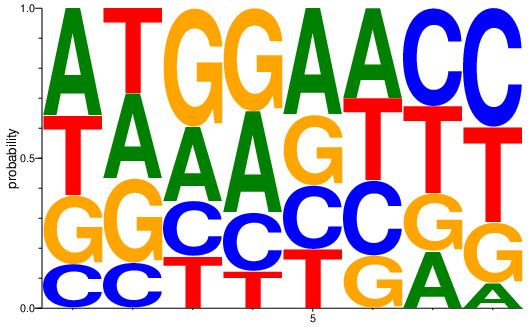

In [5]:
seqlogo.seqlogo(seqlogo.CompletePm(pfm = norm_pfm.T), ic_scale=False)

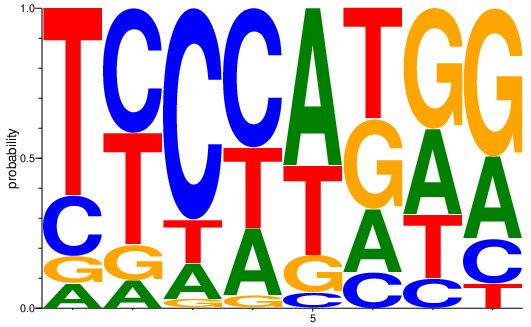

In [5]:
seqlogo.seqlogo(seqlogo.CompletePm(pfm = norm_pfm.T), ic_scale=False)

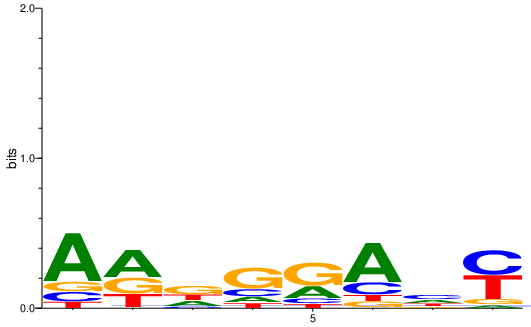

In [7]:
seqlogo.seqlogo(seqlogo.CompletePm(pfm = norm_pfm.T), ic_scale=True)

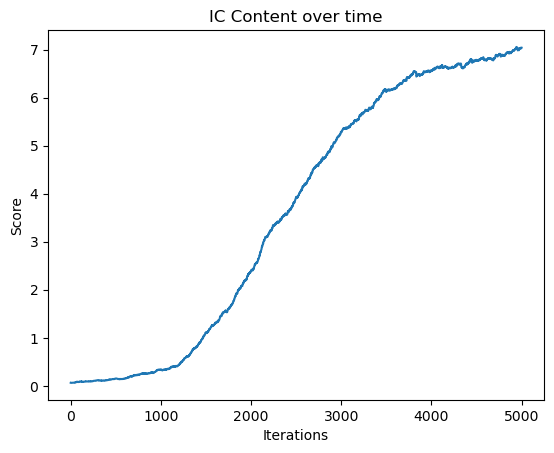

In [6]:
import matplotlib.pyplot as plt


plt.plot(ic_list)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('IC Content over time')
plt.show()